In [1]:
from neo4j import GraphDatabase

user_id = 1110008753489760261
tweet_id = 1109874238398320640
politic_usa_id = 14792049

uri = 'bolt://localhost:7687'
driver = GraphDatabase.driver(uri)

In [2]:
def retrieve_all_tweet_stories():
    message = """MATCH p=(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(start:Tweet {type: 'TWEET'})
                 WHERE NOT (start)-[:REPLIED_TO|RETWEETED_FROM]->() AND NOT ()-[:REPLIED_TO|RETWEETED_FROM]->(end)
                 WITH *, relationships(p) AS r
                 RETURN end.created_at, start.created_at, r"""
    records = driver.session().run(message).data()
    return records

In [3]:
def retrieve_tweet_story(tweet_id):
    message = """MATCH p=(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(start:Tweet {type: 'TWEET'})
                 WHERE NOT (start)-[:REPLIED_TO|RETWEETED_FROM]->() AND NOT ()-[:REPLIED_TO|RETWEETED_FROM]->(end)
                 AND start.id = {id}
                 WITH *, relationships(p) AS r
                 RETURN end.created_at, start.created_at, r"""
    records = driver.session().run(message, id=tweet_id).data()
    return records

In [4]:
def retrieve_users_who_interacted_at_a_story(tweet_id):
    message = """MATCH u=(user:User)-[:TWEETED|POSTED_REPLY|POSTED_RETWEET]->(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(start:Tweet)<-[:TWEETED]-(storyStarter:User)
                 WHERE start.id = {id} AND (end.type = 'RETWEET' OR end.type = 'REPLY') AND start.type = 'TWEET'
                 RETURN user, storyStarter"""
    records = driver.session().run(message, id=tweet_id).data()
    return records

In [5]:
def retrieve_stories_where_user_is_involved(user_id):
    message = """MATCH u=(user:User)-[:TWEETED|POSTED_REPLY|POSTED_RETWEET]->(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(start:Tweet)<-[:TWEETED]-(storyStarter:User)
                 WHERE user.id = {id} or storyStarter.id = {id} AND (end.type = 'RETWEET' OR end.type = 'REPLY') AND start.type = 'TWEET'
                 WITH *, relationships(u) as re
                 RETURN end, re, start, user, storyStarter"""
    records = driver.session().run(message, id=user_id).data()
    return records

In [6]:
def retrieve_tweet_chain_ordered_by_time(tweet_id):
    # not needed, tweet chains are created in order in the first place
    print()

In [7]:
def retrieve_stories_made_by_user(user_id):
    message = """MATCH u=(user:User)-[:TWEETED]->(tweet:Tweet)
                 WHERE user.id = {id}
                 MATCH p=(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(tweet:Tweet)
                 WHERE end.type = 'RETWEET' OR end.type = 'REPLY' AND tweet.type = 'TWEET'
                 RETURN u"""
    records = driver.session().run(message, id=user_id).value()
    return records

In [8]:
def retrieve_time_spread_of_tweet_story(tweet_id):
    records = retrieve_tweet_story(tweet_id)[0]
    start_time = records['start.created_at']
    end_time = records['end.created_at']
    message = "Original tweet was posted on %s. \nLast available reaction was posted on %s." % (start_time, end_time)
    
    return message

In [9]:
def trial_and_error(tweet_id):
    message = """MATCH u=(user:User)-[r:POSTED_REPLY|POSTED_RETWEET]->(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(start:Tweet {id: {id}, type: 'TWEET'})<-[:TWEETED]-(storyStarter:User)
                 WHERE end.type = 'RETWEET' OR end.type = 'REPLY'
                 RETURN user, end.created_at as timestamp"""
    records = driver.session().run(message, id=tweet_id).data()
    return records

In [10]:
def get_users_from_tweet_story(tweet_id):
    message = """MATCH u=(user:User)-[r:POSTED_REPLY|POSTED_RETWEET]->(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(start:Tweet {id: {id}, type: 'TWEET'})<-[:TWEETED]-(storyStarter:User)
                 WHERE end.type = 'RETWEET' OR end.type = 'REPLY'
                 RETURN user.screen_name as user, end.created_at as timestamp, storyStarter.screen_name as starter, start.created_at as origin"""
    records = driver.session().run(message, id=tweet_id).data()
    return records

In [11]:
def check_if_source_follows_target(source, target):
    message = "MATCH u=({screen_name: {source}})-[:FOLLOWS]->({screen_name: {target}}) RETURN u"
    records = driver.session().run(message, source=source, target=target).values()
    return records

In [12]:
if check_if_source_follows_target('erinbaby', 'politicususa'):
    print('hello')
print(check_if_source_follows_target('erinbaby', 'politicususa'))

hello
[[<Path start=<Node id=77671 labels={'User'} properties={'followers': 354, 'id': 1109874352479047680, 'screen_name': 'erinbaby', 'friends': 457}> end=<Node id=68621 labels={'User'} properties={'followers': 68790, 'id': 14792049, 'screen_name': 'politicususa', 'friends': 4015}> size=1>]]


In [14]:
# print(retrieve_tweet_story(1109874238398320640))
# print(retrieve_users_who_interacted_at_a_story(1109874238398320640))
# for value in retrieve_stories_made_by_user(politic_usa_id):
#     print(value)
#     print("HELLO DARKNESS WORLD")
#     print("\n")

# print(retrieve_time_spread_of_tweet_story(tweet_id))

# print(retrieve_users_who_interacted_at_a_story(tweet_id))
# print(trial_and_error(tweet_id))

listOfIds = [1109973027255664643,
    1109953086108381185,
    1109973771371376640,
    1109983287240474624,
    1109850542950531073,
    1109790735367200773,
    1109738825738117120,
    1109922557959000064,
    1109957082722250753,
    1109940939555065857,
    1110001365068251137,
    1109791857775661056,
    1109874238398320640,
    1109884141581918208]
# for tw_id in listOfIds:
#     print('hello')
results = get_users_from_tweet_story(tweet_id)
obj = {
        'user': results[0]['starter'],
        'timestamp': results[0]['origin'],
        'followers': []
    }
listOfUsers = [obj]
for record in results:
    obj = {
        'user': record['user'],
        'timestamp': record['timestamp'],
        'followers': []
    }
    listOfUsers.append(obj)

# print(listOfUsers)
for user in listOfUsers:
#     followers = []
    for i in range(1,len(listOfUsers) - 1):
        if user['user'] != listOfUsers[i]['user'] and check_if_source_follows_target(listOfUsers[i]['user'], user['user']):
            if listOfUsers[i]['user'] not in user['followers']:
                user['followers'].append(listOfUsers[i]['user'])
#     record['followers'] = followers
for record in listOfUsers:
    print(record)

{'user': 'politicususa', 'timestamp': 'Sun Mar 24 17:46:53 EET 2019', 'followers': ['erinbaby', 'MiamiNice57', 'silverthornn264', 'MarianMme16513', 'WhobbaBobba', 'Hattonsu', 'vinkoview', 'Mr_Scorpio', 'Bgolden53', 'MSMABAILEY', 'AwakenWholeness', 'maxthecat2000', 'MaryC_mlc4123', 'laleumen', 'syringa11', 'PolitiSmoose672', 'wininmad', 'evaleegifford11', 'genezog7', '7dnetwork', 'princessearl1st', 'LvnCali', 'mcp_pol', 'santo_aol', 'RBRB1516', 'maggievoelker', 'DianaSc99717236', 'Planelady1', 'StockScout1', 'FrenchieCat', 'wil91116385', 'gaelbill', 'chatta_girl', 'JohnnyHeldt', 'PolitJunkieM', 'cornerboy102000', 'purr10', 'barbara_kobrin', 'gramophoneman', 'Longley321']}
{'user': 'erinbaby', 'timestamp': 'Sun Mar 24 17:47:20 EET 2019', 'followers': []}
{'user': 'MiamiNice57', 'timestamp': 'Sun Mar 24 17:47:25 EET 2019', 'followers': ['sean_prevost']}
{'user': 'silverthornn264', 'timestamp': 'Sun Mar 24 17:48:18 EET 2019', 'followers': []}
{'user': 'MarianMme16513', 'timestamp': 'Sun Ma

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

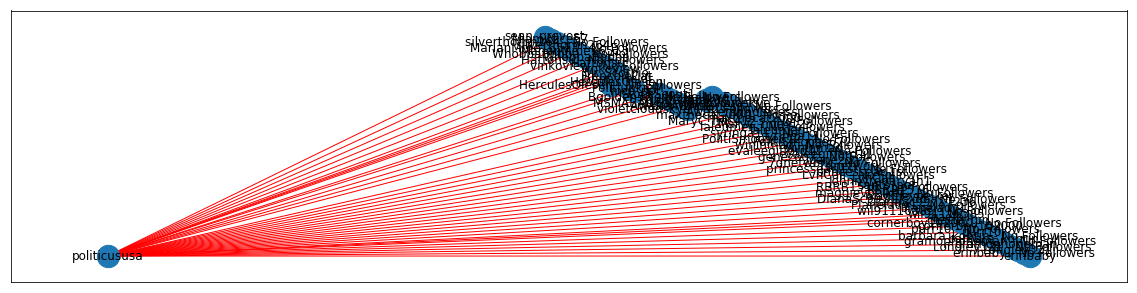

<Figure size 2160x1440 with 0 Axes>

[('politicususa', 'erinbaby'),
 ('politicususa', 'MiamiNice57'),
 ('politicususa', 'silverthornn264'),
 ('politicususa', 'MarianMme16513'),
 ('politicususa', 'WhobbaBobba'),
 ('politicususa', 'Hattonsu'),
 ('politicususa', 'vinkoview'),
 ('politicususa', 'Mr_Scorpio'),
 ('politicususa', 'Bgolden53'),
 ('politicususa', 'MSMABAILEY'),
 ('politicususa', 'AwakenWholeness'),
 ('politicususa', 'maxthecat2000'),
 ('politicususa', 'MaryC_mlc4123'),
 ('politicususa', 'laleumen'),
 ('politicususa', 'syringa11'),
 ('politicususa', 'PolitiSmoose672'),
 ('politicususa', 'wininmad'),
 ('politicususa', 'evaleegifford11'),
 ('politicususa', 'genezog7'),
 ('politicususa', '7dnetwork'),
 ('politicususa', 'princessearl1st'),
 ('politicususa', 'LvnCali'),
 ('politicususa', 'mcp_pol'),
 ('politicususa', 'santo_aol'),
 ('politicususa', 'RBRB1516'),
 ('politicususa', 'maggievoelker'),
 ('politicususa', 'DianaSc99717236'),
 ('politicususa', 'Planelady1'),
 ('politicususa', 'StockScout1'),
 ('politicususa', 'F

In [96]:
G = nx.DiGraph()
level = 0
for user in listOfUsers:
    level += 1
    G.add_node(user['user'], level=level)
    level += 1
    if not user['followers']:
        G.add_edge(user['user'], user['user'] + ' - No Followers')
    for follower in user['followers']:
        G.add_node(follower, level=level)
        G.add_edge(user['user'], follower, weight=counter * 2)
        
pos = nx.planar_layout(G)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 500)
nx.draw_networkx_edges(G, pos, edge_color='r', arrows=True)

plt.show()

In [38]:
# MATCH u=(user:User)-[r:TWEETED|POSTED_REPLY|POSTED_RETWEET]->(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(start:Tweet {id: 1109874238398320640, type: 'TWEET'})<-[:TWEETED]-(storyStarter:User)
# WHERE end.type = 'RETWEET' OR end.type = 'REPLY'
# WITH collect(user) as users, storyStarter, collect(end) as tweets, r, start
# UNWIND users AS user
# UNWIND tweets AS tweet
# MATCH pa=(someone:User)-[:POSTED_REPLY|POSTED_RETWEET]->(post:Tweet)-[:REPLIED_TO|RETWEETED_FROM]->(tweet)<-[:POSTED_REPLY|POSTED_RETWEET]-(user)
# WHERE post.created_at < tweet.created_at AND (exists((user)-[:FOLLOWS]->(someone)) OR exists((user)-[:FOLLOWS]->(storyStarter)))
# RETURN someone, user


In [ ]:
# MATCH u=(user:User)-[r:TWEETED|POSTED_REPLY|POSTED_RETWEET]->(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(start:Tweet {id: 1109874238398320640, type: 'TWEET'})<-[:TWEETED]-(storyStarter:User)
# WHERE end.type = 'RETWEET' OR end.type = 'REPLY'
# RETURN u


In [ ]:
# MATCH u=(user:User)-[r:TWEETED|POSTED_REPLY|POSTED_RETWEET]->(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(start:Tweet {id: 1109874238398320640, type: 'TWEET'})<-[:TWEETED]-(storyStarter:User)
# WHERE end.type = 'RETWEET' OR end.type = 'REPLY'
# WITH collect(user) as users, storyStarter, collect(end) as tweets, r
# RETURN users, storyStarter

In [ ]:
# MATCH u=(user:User)-[r:TWEETED|POSTED_REPLY|POSTED_RETWEET]->(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(start:Tweet {id: 1109874238398320640, type: 'TWEET'})<-[:TWEETED]-(storyStarter:User)
# WHERE end.type = 'RETWEET' OR end.type = 'REPLY'
# WITH collect(user) as users, storyStarter, collect(end) as tweets, r, start
# RETURN tweets, start

In [14]:
import os, json
import networkx as nx
import matplotlib.pyplot as plt

In [40]:
listOfUsersInFiles = []
for dirpath, dirnames, filenames in os.walk("data/stories/eight"):
    for filename in filenames:
        with open(os.path.join(dirpath, filename)) as f:
            print('\n',filename)
            listOfUsers = []
            lines = f.readlines()
            for line in lines:
                line = line.split("\n")[0]
                user = line.split(",", 2)
                followers = user[2].split("[")[1].split("]")[0].split(",")
                obj = {
                    'user': user[0],
                    'timestamp': user[1],
                    'followers': followers
                }
                
                listOfUsers.append(obj)
            listOfUsersInFiles.append(listOfUsers)


 1099774228994420737.txt

 1100056351584239619.txt

 1099511061953294336.txt

 1099790746134241283.txt

 1099775353038417920.txt

 1099700578047967232.txt

 1100737937434644480.txt

 1099366365016682496.txt


In [41]:
with open("8stories.json", "w") as f:
    f.write(json.dumps(listOfUsersInFiles, indent=2))

In [2]:
# User JSON file generation from the follows files.
# The JSON files helps us plot the network graph
import os, json, time
folderName = "latest"
start = time.time()
def parse_user_from(line):
    split = line.replace("\n", "").replace("[","").replace("]", "").split(",")
    return {
        'screen_name': split[0],
        'tweet': split[1],
        'followers': list(split[2:])
    }
    
for dirpath, dirnames, filenames in os.walk(f"data/relationships/{folderName}/follows"):
    for filename in filenames:
        tweetID = filename.split(".")[0]
        users = []
        
        with open(os.path.join(dirpath, filename)) as f:
            users = [parse_user_from(line) for line in f.readlines()]
        
        users_with = []
        for user in users:
            followers = set([follower for follower in user['followers'] for i in users 
                              if follower == i['screen_name'] and i['tweet'] > user['tweet']])
            users_with.append({
                'screen_name': user['screen_name'],
                'tweet': user['tweet'],
                'followers': [follower for follower in followers]
            })
        with open(f"data/relationships/{folderName}/json/{tweetID}.json", "w") as write_file:
            json.dump(users_with, write_file, indent=2)     
            
end = time.time()
print(end - start)

0.07050299644470215


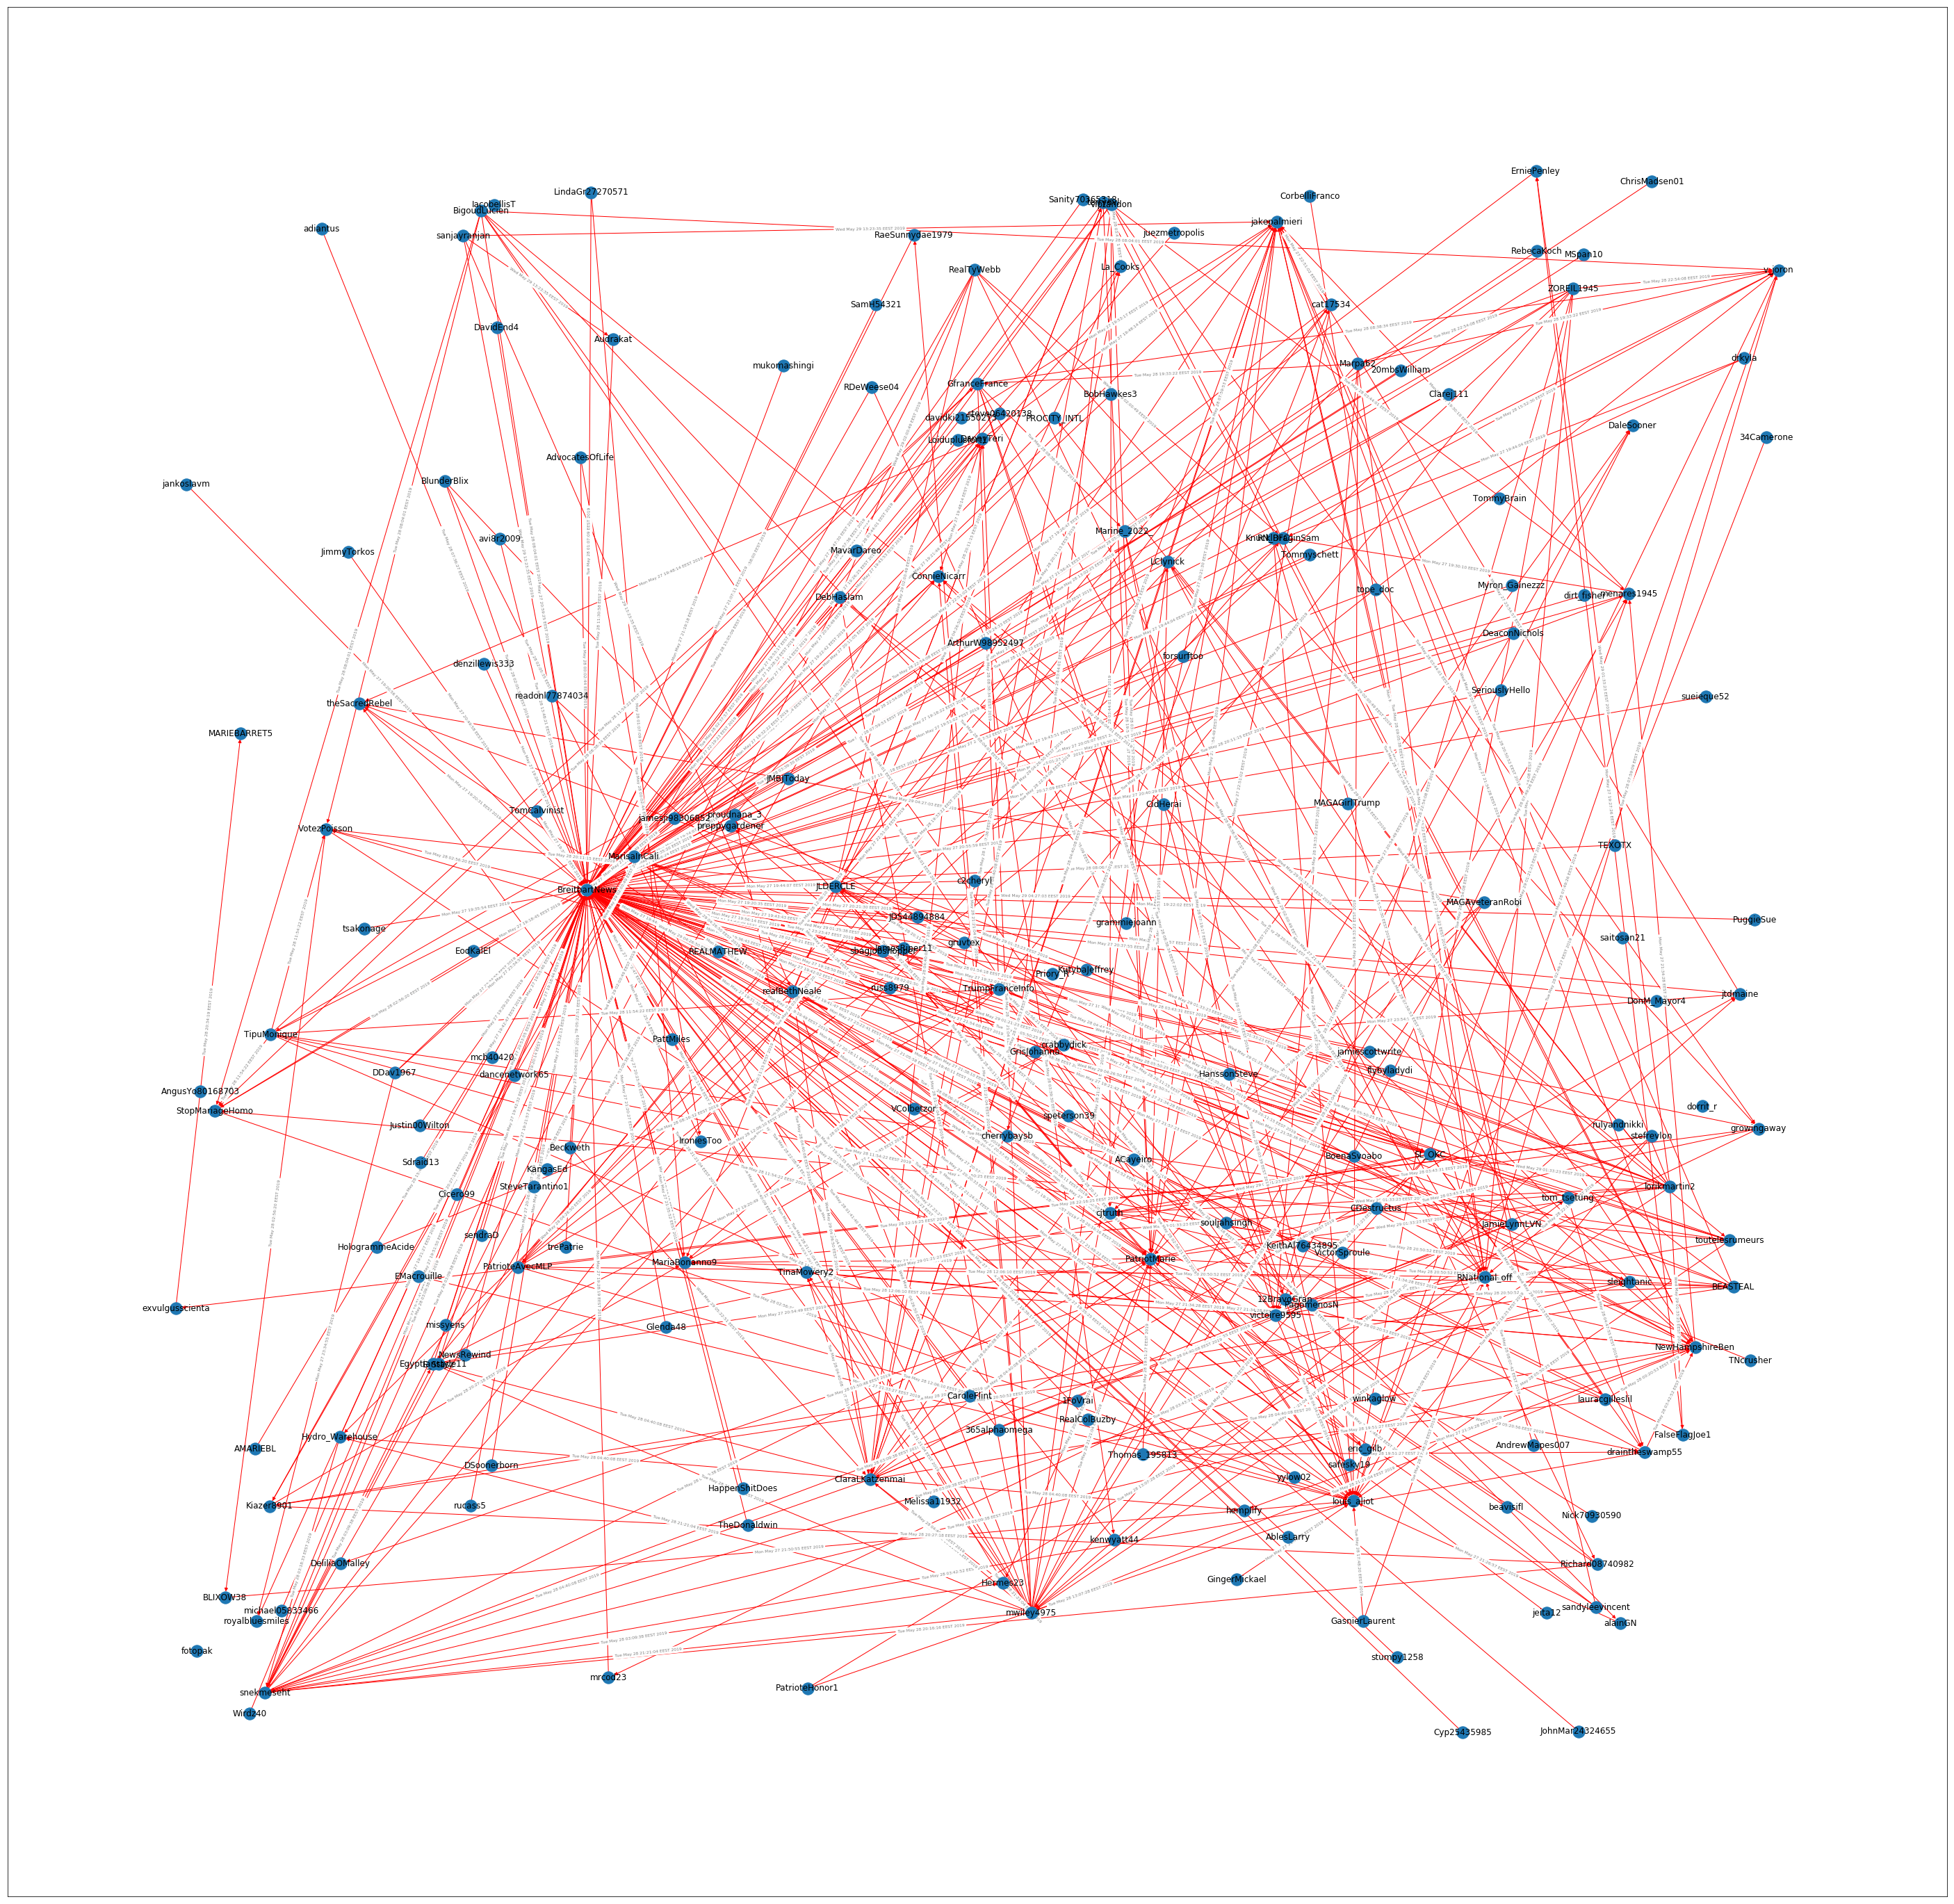

In [2]:
import networkx as nx
import json
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 50))

filename = "data/relationships/june/json/1133089990576095232.json"
users = {}
with open(filename, 'r') as f:
    users = json.load(f)
    
G = nx.DiGraph()

for user in users:
    if not G.has_node(user['screen_name']):
        G.add_node(user['screen_name'])
    for follower in user['followers']:
        if not G.has_node(follower):
            G.add_node(follower)
        if not G.has_edge(follower, user['screen_name']):
            G.add_edge(follower, user['screen_name'])
        
pos = nx.random_layout(G)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_nodes(G, pos, node_size = 300)
nx.draw_networkx_edges(G, pos, edge_color='r', arrows=True)
edge_labels = dict([((u,v),user['tweet']) for u,v in G.edges for user in users if u == user['screen_name']])
nx.draw_networkx_edge_labels(G, pos, edge_labels, alpha=0.5, font_size=6)
            
# plt.savefig("1133089990576095232.png", format="PNG")
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

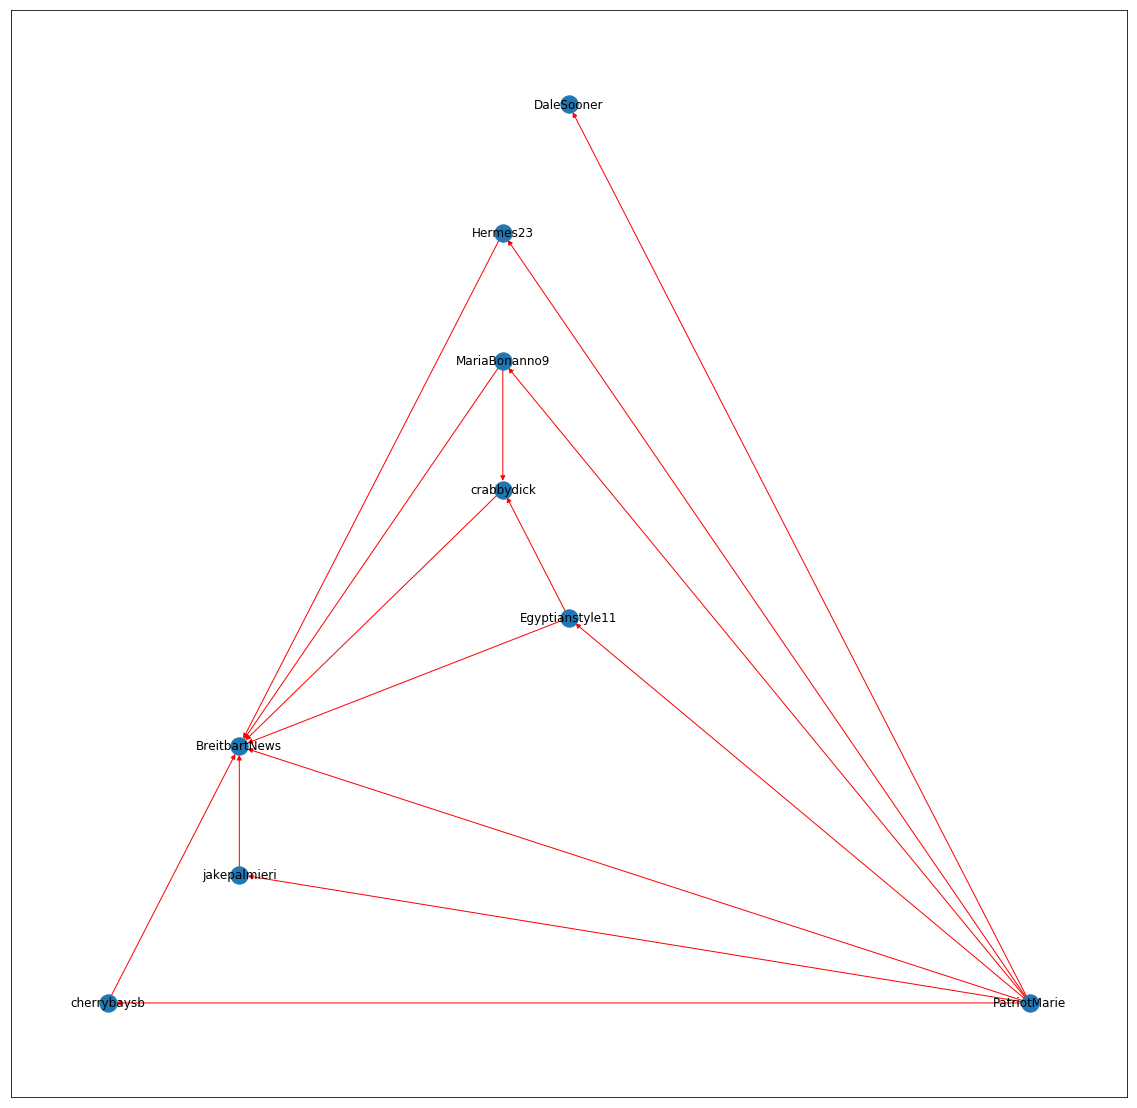

In [3]:
# Generating a subgraph, from a given node to the origin

plt.figure(figsize=(20, 20))

def subgraph_from_node(node):
    nodes = [node]
    
    queue = [neighbor for neighbor in G.neighbors(node)]
    while queue:
        next_one = queue.pop()
        if next_one not in nodes:
            nodes.append(next_one)
        queue.extend(neighbor for neighbor in G.neighbors(next_one))
    return nodes

subgraph = G.subgraph(subgraph_from_node("PatriotMarie"))

pos2 = nx.planar_layout(subgraph)
nx.draw_networkx_labels(subgraph, pos2)
nx.draw_networkx_nodes(subgraph, pos2, node_size = 300)
nx.draw_networkx_edges(subgraph, pos2, edge_color='r', arrows=True)

plt.show

In [4]:
"""
SimRank similarity of the subgraph nodes using
the networkx algorithm
"""
print(nx.simrank_similarity(subgraph))

Hello World
{'jakepalmieri': {'jakepalmieri': 1, 'cherrybaysb': 0.9, 'Hermes23': 0.9, 'MariaBonanno9': 0.45, 'Egyptianstyle11': 0.45, 'crabbydick': 0.9, 'DaleSooner': 0.0, 'BreitbartNews': 0.0, 'PatriotMarie': 0.12857142857142856}, 'cherrybaysb': {'jakepalmieri': 0.9, 'cherrybaysb': 1, 'Hermes23': 0.9, 'MariaBonanno9': 0.45, 'Egyptianstyle11': 0.45, 'crabbydick': 0.9, 'DaleSooner': 0.0, 'BreitbartNews': 0.0, 'PatriotMarie': 0.12857142857142856}, 'Hermes23': {'jakepalmieri': 0.9, 'cherrybaysb': 0.9, 'Hermes23': 1, 'MariaBonanno9': 0.45, 'Egyptianstyle11': 0.45, 'crabbydick': 0.9, 'DaleSooner': 0.0, 'BreitbartNews': 0.0, 'PatriotMarie': 0.12857142857142856}, 'MariaBonanno9': {'jakepalmieri': 0.45, 'cherrybaysb': 0.45, 'Hermes23': 0.45, 'MariaBonanno9': 1, 'Egyptianstyle11': 0.45, 'crabbydick': 0.45, 'DaleSooner': 0.0, 'BreitbartNews': 0.0, 'PatriotMarie': 0.29571428571428576}, 'Egyptianstyle11': {'jakepalmieri': 0.45, 'cherrybaysb': 0.45, 'Hermes23': 0.45, 'MariaBonanno9': 0.45, 'Egyptia

In [44]:
"""
An implementation of the SimRank Algorithm
based on the networkx implementation.
"""
from itertools import product
from numpy import array

def _is_close(d1, d2, atolerance=0, rtolerance=0):
    if not isinstance(d1, dict) and not isinstance(d2, dict):
        return abs(d1 - d2) <= atolerance + rtolerance * abs(d2)
    return all(all(_is_close(d1[u][v], d2[u][v]) for v in d1[u]) for u in d1)

def simrank_similarity(G, source=None, target=None, importance_factor=0.9,
                       max_iterations=100, tolerance=1e-4):
    prevsim = None

    # build up our similarity adjacency dictionary output
    newsim = {u: {v: 1 if u == v else 0 for v in G} for u in G}

    # These functions compute the update to the similarity value of the nodes
    # `u` and `v` with respect to the previous similarity values.
    avg_sim = lambda s: sum(newsim[w][x] for (w, x) in s) / len(s) if s else 0.0
    sim = lambda u, v: importance_factor * avg_sim(list(product(G[u], G[v])))
#     def avg_sim(s):

#         if not s:
#             return 0
#         return sum(newsim[w][x] for (w, x) in s) / len(s)
#     def sim(u,v):
#         return importance_factor * avg_sim(list(product(G[u], G[v])))
    
    for _ in range(max_iterations):
        if prevsim and _is_close(prevsim, newsim, tolerance):
            break
        prevsim = newsim
        newsim = {u: {v: sim(u, v) if u is not v else 1
                      for v in newsim[u]} for u in newsim}

    if source is not None and target is not None:
        return newsim[source][target]
    if source is not None:
        return newsim[source]
    return newsim
print(simrank_similarity(G))
a = 3

print("one") if a == 1 else("two" if a ==2 else "None")

{'BreitbartNews': {'BreitbartNews': 1, 'tom_tsetung': 0.0, 'sendraD': 0.0, 'La_Cooks': 0.0, 'Cyp25435985': 0.0, 'RaeSunnydae1979': 0.0, 'StopMariageHomo': 0.0, 'Sanity70365318': 0.0, 'MAGAveteranRobi': 0.0, 'SamH54321': 0.0, 'Priory_R': 0.0, 'PuggieSue': 0.0, 'crabbydick': 0.0, 'viptandon': 0.0, 'DDav1967': 0.0, 'tope_doc': 0.0, 'AMARIEBL': 0.0, 'BobHawkes3': 0.0, 'dirt_fisher': 0.0, 'Hydro_Warehouse': 0.0, 'mukomashingi': 0.0, 'dancenetwork65': 0.0, 'winkaglow': 0.0, 'CaroleFlint': 0.0, 'KnucklDraginSam': 0.0, 'flybyladydi': 0.0, 'Sdraid13': 0.0, 'Cicero99': 0.0, 'gruvtex': 0.0, 'ACayeiro': 0.0, 'TNcrusher': 0.0, 'adiantus': 0.0, 'BEASTEAL': 0.0, 'KutybaJeffrey': 0.0, 'MariaBonanno9': 0.0, 'terrydvl': 0.0, 'Wirdz40': 0.0, 'MarisaInCali': 0.0, 'steve06420138': 0.0, '20mbsWilliam': 0.0, 'JDS44894884': 0.0, 'MAGAGirlTrump': 0.0, 'RDeWeese04': 0.0, 'Tommyschett': 0.0, 'JimmyTorkos': 0.0, 'BoenaSvoabo': 0.0, 'eric_gilb': 0.0, 'preppygardener': 0.0, 'davidki21550273': 0.0, 'MSpan10': 0.0, '

'None'

In [12]:
print(list(nx.dfs_edges(G, "jakepalmieri")))
print(nx.is_directed_acyclic_graph(G))

print(list(nx.all_simple_paths(G, "jakepalmieri", "BreitbartNews")))

for i in G.neighbors("PatriotMarie"):
    print(i)

[('jakepalmieri', 'BreitbartNews')]
False
[['jakepalmieri', 'BreitbartNews']]
BreitbartNews
cherrybaysb
Egyptianstyle11
jakepalmieri
Hermes23
DaleSooner
MariaBonanno9


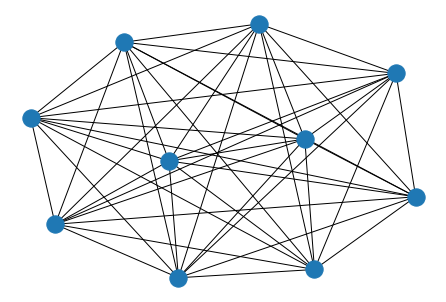

<Figure size 432x288 with 0 Axes>

9


In [20]:
G = nx.complete_graph(10)
nx.draw(G)
plt.figure()
plt.show()

nx.simrank_similarity(G)
print(G.degree(1))

In [3]:
# Generating graphs for all stories
# And saving those graphs as png images,
import os, json, time
import networkx as nx
import matplotlib.pyplot as plt

start = time.time()
folderNames = ["june", "latest"]

plt.ioff()

for folderName in folderNames:
    for dirpath, dirnames, filenames in os.walk(f"data/relationships/{folderName}/json"):
        for filename in filenames:
            tweetID = filename.split(".")[0]

            users = {}
            with open(os.path.join(dirpath, filename), 'r') as f:
                users = json.load(f)
            
            fig = plt.figure(figsize=(50, 50))
            G = nx.DiGraph()

            for user in users:
                if not G.has_node(user['screen_name']):
                    G.add_node(user['screen_name'])
                for follower in user['followers']:
                    if not G.has_node(follower):
                        G.add_node(follower)
                    if not G.has_edge(follower, user['screen_name']):
                        G.add_edge(follower, user['screen_name'])

            pos = nx.random_layout(G)
            nx.draw_networkx_labels(G, pos)
            nx.draw_networkx_nodes(G, pos, node_size = 300)
            nx.draw_networkx_edges(G, pos, edge_color='r', arrows=True)
            edge_labels = dict([((u,v),user['tweet']) for u,v in G.edges for user in users if u == user['screen_name']])
            nx.draw_networkx_edge_labels(G, pos, edge_labels, alpha=0.5, font_size=6)

            plt.savefig(f"static/{folderName}/{tweetID}.png", format="PNG")    
            plt.close(fig)

end = time.time()
print(end - start)

67.76170110702515
